# 1. Importing libraries

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import copy

# 2. Loading the dataset

In [47]:
# link: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset
df = pd.read_csv("dataset/breast-cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# 3. Train/test splitting and normalization

In [48]:
df_columns = list(df.columns)
df_columns.remove('diagnosis')
df_columns.remove('id')
features = df_columns

X = df[features]
y = df['diagnosis']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

indices = np.arange(len(y))
(
    X_train, 
    X_test, 
    y_train, y_test, train_idx, test_idx )= train_test_split(X, y, indices, test_size=0.3, random_state=40)

# 4. Accuracy report function

In [49]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label,label]/np.sum(cm[label,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

# 5. SVM Classification with RBF Kernel

In [224]:
C = 12.6
gamma = 0.973

svm = SVC(kernel='rbf', C=C, gamma=gamma)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
acc_report = accuracy_report(y_test, y_pred)

acc_report_df = pd.DataFrame(acc_report.values(), columns=["OF"],  index=acc_report.keys())
acc_report_df

,OF
class 0,99.130435
class 1,98.214286
OA,98.830409
AA,98.672360


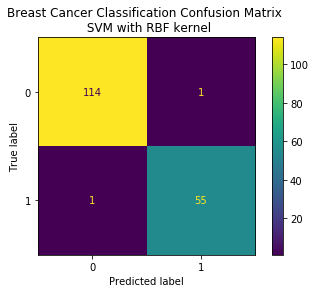

In [211]:
cm = confusion_matrix(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
disp.plot()
plt.title("Breast Cancer Classification Confusion Matrix \n SVM with RBF kernel")
plt.show()

# 6. K-means Clustering

In [52]:
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)

C:\Users\Asma\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Asma\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  "KMeans is known to have a memory leak on Windows "


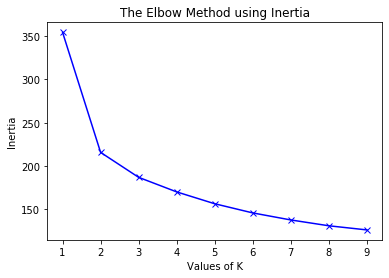

In [53]:

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [226]:
n_clusters = 4
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters, # 4 works better
    n_init=100,
    max_iter=1000,
    random_state=42
)
kmeans.fit(X)
y_pred_k_clusters = kmeans.predict(X)

# SVM OF + Mean of clusters

In [227]:
X2 = np.zeros(X.shape)
mean_features_r
for k_label in np.unique(y_pred_k_clusters):
    features_per_cluster = X[y_pred_k_clusters==k_label]
    mean_features = np.mean(features_per_cluster, axis=0)
    mean_features = np.reshape(mean_features, (1, 30))
    mean_features_r = np.repeat(mean_features, repeats=features_per_cluster.shape[0], axis=0)
    X2[y_pred_k_clusters==k_label]=mean_features_r
X2 = np.concatenate((X, X2), axis=1)
X2.shape

X2_train = X2[train_idx]
X2_test = X2[test_idx]

C = 12.6
gamma = 0.973

svm = SVC(kernel='rbf', C=C, gamma=gamma)
svm.fit(X2_train, y_train)
y_pred = svm.predict(X2_test)
acc_report = accuracy_report(y_test, y_pred)

acc_report_df["OF + mean features (k = "+str(n_clusters)+")"] = acc_report.values()
acc_report_df

,OF,OF + mean features (k = 3),OF + mean features (k = 4)
class 0,99.130435,100.000000,100.000000
class 1,98.214286,96.428571,98.214286
OA,98.830409,98.830409,99.415205
AA,98.672360,98.214286,99.107143


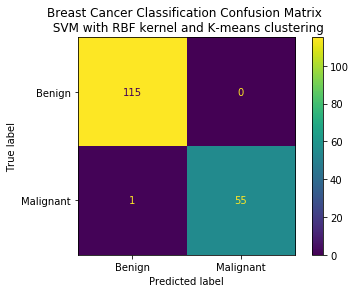

In [217]:
cm = confusion_matrix(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Benign", "Malignant"])
disp.plot()
plt.title("Breast Cancer Classification Confusion Matrix \n SVM with RBF kernel and K-means clustering")
plt.show()